In [2]:
# deps
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd.forward_ad as fwAD
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import datasets

In [31]:
# functional implementation seems to be easier than nn.Module
# for now, just a linear map
# TODO: build a framework that makes this easier to use (eg. with classes)
def predict(x, w, b):
    return F.softmax(F.linear(x, w, b), dim=0)

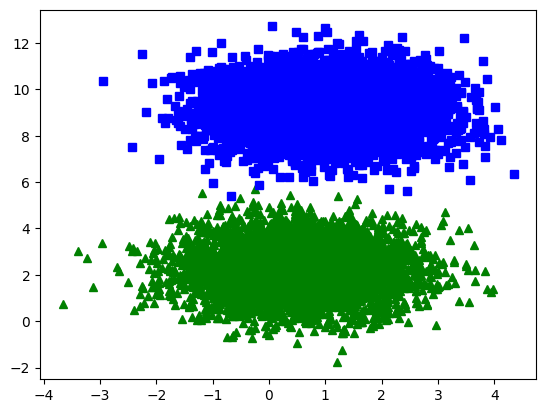

In [57]:
# generate (linearly separable) data
X, y = datasets.make_blobs(n_samples=10000, centers=2, n_features=2, center_box=(0, 10))
X = torch.tensor(X, dtype=torch.float32)

plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')

y = F.one_hot(torch.tensor(y), 2).float()

In [61]:
# initialize weight and bias
w = torch.randn(2, 2)
b = torch.randn(2)

losses = []

# generate orthonormal tangent vectors (TODO: randomize this)
tans = [torch.eye(2, 2+1) for _ in range(10000)]

with tqdm(zip(X[:8000], y[:8000], tans)) as pbar:
    for input, target, tan in pbar:
        # I think this disables autograd? TODO: check
        with fwAD.dual_level():
            w_tan = tan[:, :-1]
            b_tan = tan[:, -1]
            # we only need w and b to be dual, not input
            # this is because unspecified tangents are implicitly 0
            dual_w = fwAD.make_dual(w, w_tan)
            dual_b = fwAD.make_dual(b, b_tan)
            dual_output = predict(input, dual_w, dual_b)
            try:
                dual_loss = F.binary_cross_entropy(dual_output, target)
            except Exception as e:
                # sometimes we get NaNs, try and figure out why?
                print(dual_output, target)
                print(dual_w)
                print(dual_b)
                print(out)
                print(losses[-5:])
                raise e

            # namedtuple (primal, tangent)
            out = fwAD.unpack_dual(dual_loss)

            losses.append(out.primal.item())

            # I think this is the correct way to do this?
            # TODO: momentum
            w -= out.tangent * 0.01 * w_tan
            b -= out.tangent * 0.01 * b_tan
        
        acc = (predict(X[8000:], w, b).argmax(dim=1) == y[8000:].argmax(dim=1)).float().mean()
        pbar.set_description(f"loss: {losses[-1]:.4f} acc: {acc:.4f}")


loss: 0.0267 acc: 0.6170: : 8000it [00:04, 1714.53it/s]


In [67]:
# see how well we can do with normal gradient descent

w_b = torch.randn(2, 2, requires_grad=True)
b_b = torch.randn(2, requires_grad=True)

losses_b = []

with tqdm(zip(X[:8000], y[:8000], tans)) as pbar:
    for input, target, tan in pbar:
        if w_b.grad is not None:
            w_b.grad.detach_()
            w_b.grad.zero_()
        if b_b.grad is not None:
            b_b.grad.detach_()
            b_b.grad.zero_()

        out = predict(input, w_b, b_b)

        loss = F.binary_cross_entropy(out, target)
        loss.backward()

        losses_b.append(loss.item())

        with torch.no_grad():
            w_b -= w_b.grad * 0.01
            b_b -= b_b.grad * 0.01
    
    acc = (predict(X[8000:], w, b).argmax(dim=1) == y[8000:].argmax(dim=1)).float().mean()
    pbar.set_description(f"loss: {losses_b[-1]:.4f} acc: {acc:.4f}")


8000it [00:00, 10092.52it/s]


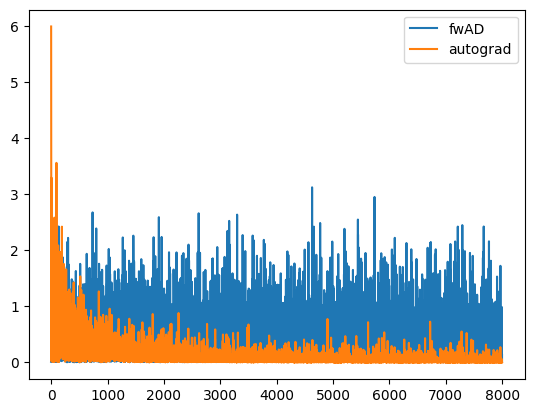

In [70]:
plt.plot(losses, label='fwAD')
plt.plot(losses_b, label='autograd')
plt.legend()